# Preference Learning - Part VI
## Comparison of warm and cold season k-mean

In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import seaborn as sns
import math
from pandas.io.json import json_normalize #package for flattening json in pandas df
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime

In [ ]:
# Import all preprocessed data necessary for the analysis
df_tou1h = pd.read_csv("C:\\Users\\Rockwell\\Desktop\\Paper4\\data_collection\\data_tables\\Consumption_tou2013_1h.csv")
df_Ntou1h = pd.read_csv("C:\\Users\\Rockwell\\Desktop\\Paper4\\data_collection\\data_tables\\Consumption_Ntou2013_1h.csv")
df_wea1h = pd.read_csv("C:\\Users\\Rockwell\\Desktop\\Paper4\\data_collection\\weather\\LondonWeather2013_interpolated.csv")
df_tariff_1h = pd.read_csv("C:\\Users\\Rockwell\\Desktop\\Paper4\\data_collection\\data_tables\\df_tariff_1h.csv")

In [2]:
import os
os.getcwd()

'/Users/Rockwell/Documents/GitHub/Demand-Response'

In [3]:
# for ios system, import all data necessary for the analysis
df_tou1h = pd.read_csv('/Users/Rockwell/Desktop/PhD/Paper4PreferenceLearning/data/Consumption_tou2013_1h.csv')
df_Ntou1h = pd.read_csv('/Users/Rockwell/Desktop/PhD/Paper4PreferenceLearning/data/Consumption_Ntou2013_1h.csv')
df_wea1h = pd.read_csv('/Users/Rockwell/Desktop/PhD/Paper4PreferenceLearning/data/LondonWeather2013_interpolated.csv')
df_tariff_1h = pd.read_csv('/Users/Rockwell/Desktop/PhD/Paper4PreferenceLearning/data/df_tariff_1h.csv')

In [4]:
# first, create a list of days that belongs to event days
event_days = set()
event_series = df_tariff_1h[df_tariff_1h.Event_tags.notnull()].GMT
for i in event_series:
    event_days.add(datetime.strptime(i[:10], "%Y-%m-%d" ).date()) # add all event dates to the set
df_help = pd.DataFrame(pd.to_datetime(df_tariff_1h.GMT).dt.date) #str to datatime and extract date then make it to dataframe
# df_help[df_help['GMT'].isin(event_days)] #this shows the event days
# we can use ~df_help['GMT'].isin(event_days) to generate any non-flexible period items

# create TOU and non-TOU demand data in non-flexible hours
df_wea1h_nf = df_wea1h[~df_help['GMT'].isin(event_days)]
df_Ntou1h_nf = df_Ntou1h[~df_help['GMT'].isin(event_days)]
df_tou1h_nf = df_tou1h[~df_help['GMT'].isin(event_days)]

# create event data
df_tariff_1h_event = df_tariff_1h[df_tariff_1h.GMT.isin(event_series)]
df_wea1h_event = df_wea1h[df_wea1h.GMT.isin(event_series)]
df_tou1h_event = df_tou1h[df_tou1h.GMT.isin(event_series)]

In [5]:
# seperate the above data set based on the seasonal effect
# i.e., months of 11, 12, 1, 2, 3 are in a group - cold season
# months of 4, 5, 6, 7, 8, 9, 10 are in another group - warm season
cold_season = [11, 12, 1, 2, 3]
warm_season = [4, 5, 6, 7, 8, 9, 10]
df_help_season = pd.DataFrame(pd.to_datetime(df_wea1h_nf.GMT).dt.month)
df_wea1h_nf_cold = df_wea1h_nf[df_help_season['GMT'].isin(cold_season)]
df_wea1h_nf_warm = df_wea1h_nf[df_help_season['GMT'].isin(warm_season)]
df_Ntou1h_nf_cold = df_Ntou1h_nf[df_help_season['GMT'].isin(cold_season)]
df_Ntou1h_nf_warm = df_Ntou1h_nf[df_help_season['GMT'].isin(warm_season)]
df_tou1h_nf_cold = df_tou1h_nf[df_help_season['GMT'].isin(cold_season)]
df_tou1h_nf_warm = df_tou1h_nf[df_help_season['GMT'].isin(warm_season)]

df_help_season_event = pd.DataFrame(pd.to_datetime(df_wea1h_event.GMT).dt.month)
df_wea1h_event_cold = df_wea1h_event[df_help_season_event['GMT'].isin(cold_season)]
df_wea1h_event_warm = df_wea1h_event[df_help_season_event['GMT'].isin(warm_season)]
df_tou1h_event_cold = df_tou1h_event[df_help_season_event['GMT'].isin(cold_season)]
df_tou1h_event_warm = df_tou1h_event[df_help_season_event['GMT'].isin(warm_season)]
df_tariff_1h_event_cold = df_tariff_1h_event[df_help_season_event['GMT'].isin(cold_season)]
df_tariff_1h_event_warm = df_tariff_1h_event[df_help_season_event['GMT'].isin(warm_season)]

## 1. Groups' Price Responsiveness - K-mean based

The way we analyze the group price responsiveness has three steps:

1) for each hosehold group, build a new dataframe, the first column is GMT, the next columns are user ids in the group, the next column is temperature, then the price, day of a week, hour of a day, then the predicted consumption, and last the price responsiveness

2) build a function that can generate predicted consumption based on the day of a week, temp, hour to choose the coefficients and then make a prediction.

3) plot the properties based on from the smallest unit (day of week, hour, temp) to (day of week, hour), (day of week, temp), (hour, temp), (day of week), (hour), (temp) so we will have very comprehensive price responsiveness of three different groups


In [45]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D 
n = 3 # cluster numbers
n_house = 1025 # total household numbers
houseLabel = [] # store the 24hour group labels for each hoursehold
hourly_label = [] # used for comparing with warm season clustering distance
for i in range(1025):
    houseLabel.append('')
houseLabel = np.array(houseLabel)
cons_type = ['High Consumption', 'Medium Consumption', 'Low Consumption']
fig_all = plt.figure(figsize = (13,90))
for i in range(24):
    if i <= 9:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.fillna(x.mean()).transpose() # data for the specific hour, and fill in null value with mean
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        kmeans_cold = KMeans(n_clusters = n, init='k-means++').fit(principleDf_nstd.iloc[:,:3])
        houseLabel = np.core.defchararray.add(houseLabel, kmeans_cold.labels_.astype('str'))
        hourly_label.append(kmeans_cold.labels_)
    else:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.fillna(x.mean()).transpose() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        kmeans_cold = KMeans(n_clusters = n, init='k-means++').fit(principleDf_nstd.iloc[:,:3])
        cluster_dict = {}
        houseLabel = np.core.defchararray.add(houseLabel, kmeans_cold.labels_.astype('str'))
        hourly_label.append(kmeans_cold.labels_)
# We obtain the house Label shown below
# print(houseLabel)

# Group the house based on their 24 hour labels
houseLableDf = pd.DataFrame()
houseLableDf['House'] = df_tou1h_nf_cold.columns[1:]
houseLableDf['Label'] = houseLabel
houseGroupDf = houseLableDf.groupby('Label').size().reset_index(name='counts')
houseGroupDf = houseGroupDf.sort_values(by=['counts'], ascending=False)
houseGroupDf

,Label,counts
115,100001000100000000211110,409
424,221210111022211121000201,29
125,100001000100000001211110,10
56,100001000000000000211110,9
191,100001001022211121000201,7
109,100001000100000000201110,7
103,100001000100000000011110,6
19,012122222211122212122022,5
286,200001000100000000211110,5
418,221210101022211121000201,5


<Figure size 936x6480 with 0 Axes>

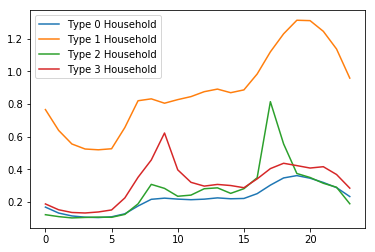

In [15]:
for i in range(4):
    load = []
    for j in range(24):
        if j <= 9:
            x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(j) + ':00:00')]
            x.set_index('GMT', inplace = True)
            x = x.fillna(x.mean())
            x = x[list(houseLableDf[houseLableDf.Label == houseGroupDf.Label.iloc[i]].House)]
            load.append(x.mean().mean())
        else:
            x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(j) + ':00:00')]
            x.set_index('GMT', inplace = True)
            x = x.fillna(x.mean())
            x = x[list(houseLableDf[houseLableDf.Label == houseGroupDf.Label.iloc[i]].House)]
            load.append(x.mean().mean())
    plt.plot(load, label = 'Type ' + str(i) + ' Household')
plt.legend()
plt.show()

### Start to find groups in warm season PCs using the clusters from cold seasons

In [68]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D 
n = 3 # cluster numbers
n_house = 1025 # total household numbers
opt_inertia = [] # store the optimal inertia list based on k-mean clustering of the corresponding season
test_inertia = [] # store the test inertia list based on the clustering result from another season
cons_type = ['High Consumption', 'Medium Consumption', 'Low Consumption']
for i in range(24):
    if i <= 9:
        x = df_tou1h_nf_warm[df_tou1h_nf_warm.GMT.str.contains('0' + str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.fillna(x.mean()).transpose() # data for the specific hour, and fill in null value with mean
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        # calculate the optimal inertia based on K-mean clustering
        kmeans = KMeans(n_clusters = n, init='k-means++').fit(principleDf_nstd.iloc[:,:3])
        opt_inertia.append(kmeans.inertia_)
        
        # calculate the test inertia based on clusters from another season
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.fillna(x.mean()).transpose() # data for the specific hour, and fill in null value with mean
        # PCA without standardization
        pca_nstd_cold = PCA()
        principleComponents_nstd_cold = pca_nstd_cold.fit_transform(x)
        principleDf_nstd_cold = pd.DataFrame(data = principleComponents_nstd_cold)
        # calculate the optimal inertia based on K-mean clustering
        kmeans_cold = KMeans(n_clusters = n, init='k-means++').fit(principleDf_nstd_cold.iloc[:,:3])
        dist = 0
        for j in range(n):
            centroid = list(principleDf_nstd.iloc[:,:3][kmeans_cold.labels_ == j].mean())
            df_diff = principleDf_nstd.iloc[:,:3][kmeans_cold.labels_ == j] - principleDf_nstd.iloc[:,:3][kmeans_cold.labels_ == j].mean()
            df_diff = df_diff.pow(2)
            dist += df_diff.sum().sum()
        test_inertia.append(dist)
    else:
        x = df_tou1h_nf_warm[df_tou1h_nf_warm.GMT.str.contains(str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.fillna(x.mean()).transpose() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        # calculate the optimal inertia based on K-mean clustering
        kmeans = KMeans(n_clusters = n, init='k-means++').fit(principleDf_nstd.iloc[:,:3])
        opt_inertia.append(kmeans.inertia_)
        # calculate the test inertia based on clusters from another season
        
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.fillna(x.mean()).transpose() # data for the specific hour, and fill in null value with mean
        # PCA without standardization
        pca_nstd_cold = PCA()
        principleComponents_nstd_cold = pca_nstd_cold.fit_transform(x)
        principleDf_nstd_cold = pd.DataFrame(data = principleComponents_nstd_cold)
        # calculate the optimal inertia based on K-mean clustering
        kmeans_cold = KMeans(n_clusters = n, init='k-means++').fit(principleDf_nstd_cold.iloc[:,:3])
        dist = 0
        for j in range(n):
            centroid = list(principleDf_nstd.iloc[:,:3][kmeans_cold.labels_ == j].mean())
            df_diff = principleDf_nstd.iloc[:,:3][kmeans_cold.labels_ == j] - principleDf_nstd.iloc[:,:3][kmeans_cold.labels_ == j].mean()
            df_diff = df_diff.pow(2)
            dist += df_diff.sum().sum()
        test_inertia.append(dist)
# The inertia difference over 24 hours in percentage
inertia_diff_rel_coldToWarm = (np.array(test_inertia) - np.array(opt_inertia)) / np.array(opt_inertia) * 100
inertia_total_diff_rel_coldToWarm = (sum(test_inertia) - sum(opt_inertia)) / sum(opt_inertia) * 100

Do the opposite: using warm season clustering to compare with cold season clustering

In [67]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D 
n = 3 # cluster numbers
n_house = 1025 # total household numbers
opt_inertia = [] # store the optimal inertia list based on k-mean clustering of the corresponding season
test_inertia = [] # store the test inertia list based on the clustering result from another season
cons_type = ['High Consumption', 'Medium Consumption', 'Low Consumption']
for i in range(24):
    if i <= 9:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.fillna(x.mean()).transpose() # data for the specific hour, and fill in null value with mean
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        # calculate the optimal inertia based on K-mean clustering
        kmeans = KMeans(n_clusters = n, init='k-means++').fit(principleDf_nstd.iloc[:,:3])
        opt_inertia.append(kmeans.inertia_)
        
        # calculate the test inertia based on clusters from another season
        x = df_tou1h_nf_warm[df_tou1h_nf_warm.GMT.str.contains('0' + str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.fillna(x.mean()).transpose() # data for the specific hour, and fill in null value with mean
        # PCA without standardization
        pca_nstd_warm = PCA()
        principleComponents_nstd_warm = pca_nstd_warm.fit_transform(x)
        principleDf_nstd_warm = pd.DataFrame(data = principleComponents_nstd_warm)
        # calculate the optimal inertia based on K-mean clustering
        kmeans_warm = KMeans(n_clusters = n, init='k-means++').fit(principleDf_nstd_warm.iloc[:,:3])
        dist = 0
        for j in range(n):
            centroid = list(principleDf_nstd.iloc[:,:3][kmeans_warm.labels_ == j].mean())
            df_diff = principleDf_nstd.iloc[:,:3][kmeans_warm.labels_ == j] - principleDf_nstd.iloc[:,:3][kmeans_warm.labels_ == j].mean()
            df_diff = df_diff.pow(2)
            dist += df_diff.sum().sum()
        test_inertia.append(dist)
    else:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.fillna(x.mean()).transpose() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        # calculate the optimal inertia based on K-mean clustering
        kmeans = KMeans(n_clusters = n, init='k-means++').fit(principleDf_nstd.iloc[:,:3])
        opt_inertia.append(kmeans.inertia_)
        # calculate the test inertia based on clusters from another season
        
        x = df_tou1h_nf_warm[df_tou1h_nf_warm.GMT.str.contains(str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.fillna(x.mean()).transpose() # data for the specific hour, and fill in null value with mean
        # PCA without standardization
        pca_nstd_warm = PCA()
        principleComponents_nstd_warm = pca_nstd_warm.fit_transform(x)
        principleDf_nstd_warm = pd.DataFrame(data = principleComponents_nstd_warm)
        # calculate the optimal inertia based on K-mean clustering
        kmeans_warm = KMeans(n_clusters = n, init='k-means++').fit(principleDf_nstd_warm.iloc[:,:3])
        dist = 0
        for j in range(n):
            centroid = list(principleDf_nstd.iloc[:,:3][kmeans_warm.labels_ == j].mean())
            df_diff = principleDf_nstd.iloc[:,:3][kmeans_warm.labels_ == j] - principleDf_nstd.iloc[:,:3][kmeans_warm.labels_ == j].mean()
            df_diff = df_diff.pow(2)
            dist += df_diff.sum().sum()
        test_inertia.append(dist)
# The inertia difference over 24 hours in percentage
inertia_diff_rel_warmToCold = (np.array(test_inertia) - np.array(opt_inertia)) / np.array(opt_inertia) * 100
inertia_total_diff_rel_warmToCold = (sum(test_inertia) - sum(opt_inertia)) / sum(opt_inertia) * 100

Note: there's no clear meaning of comparing two seperate clustering inertia in two different k-mean clusterings (because it could do better even if it's not optimal solution of k-mean clustering in terms of one specific cluster), becaue the optimization objective is to maximize the sum of inertia of all clusters, not just one of them.

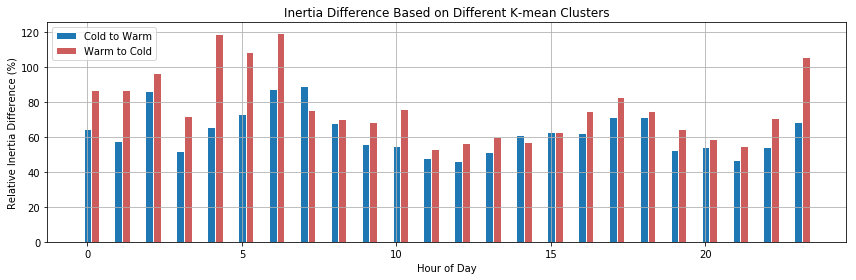

In [99]:
# plot the grouped bar charts based on price, for 3 household types
fig_all = plt.figure(figsize = (12,4))
ax_Ntou = [] # store subplot objects
# set width of bar
barWidth = 0.25
# Set position of bar on X axis
r1 = np.arange(len(inertia_diff_rel_warmToCold))
r2 = [x + barWidth for x in r1]
ax_Ntou.append(fig_all.add_subplot(1, 1, 1))
# Make the plot
ax_Ntou[-1].bar(r1, inertia_diff_rel_coldToWarm, width=barWidth, edgecolor='white', label='Cold to Warm')
ax_Ntou[-1].bar(r2, inertia_diff_rel_warmToCold, color='indianred', width=barWidth, edgecolor='white', label='Warm to Cold')
ax_Ntou[-1].grid()
ax_Ntou[-1].set_xlabel('Hour of Day')
ax_Ntou[-1].set_ylabel('Relative Inertia Difference (%)')
ax_Ntou[-1].legend()
ax_Ntou[-1].set_title('Inertia Difference Based on Different K-mean Clusters')
plt.tight_layout()

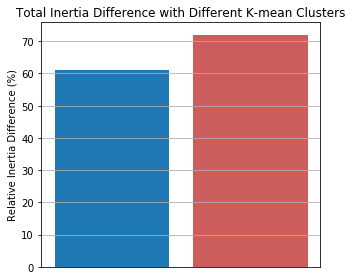

In [100]:
# plot the grouped bar charts based on price, for 3 household types
fig_all = plt.figure(figsize = (5,4))
ax_Ntou = [] # store subplot objects
# set width of bar
barWidth = 0.25
# Set position of bar on X axis
r1 = np.arange(1) - 0.125
r2 = [x + barWidth for x in r1]
ax_Ntou.append(fig_all.add_subplot(1, 1, 1))
# Make the plot
ax_Ntou[-1].bar(r1, inertia_total_diff_rel_coldToWarm, width=barWidth/1.2, edgecolor='white', label='Cold to Warm')
ax_Ntou[-1].bar(r2, inertia_total_diff_rel_warmToCold, color='indianred', width=barWidth/1.2, edgecolor='white', label='Warm to Cold')
ax_Ntou[-1].grid()
ax_Ntou[-1].set_ylabel('Relative Inertia Difference (%)')
ax_Ntou[-1].set_xticks([])
# ax_Ntou[-1].legend()
ax_Ntou[-1].set_title('Total Inertia Difference with Different K-mean Clusters')
plt.tight_layout()

So, k-mean clustering based on PCs of the corresponding seasons cannot be simply replaced by the clustering from other seasons, which shows the necessicity of considering the patterns in different seasons in the beginning of our framework design.